In [1]:
import gym
import gym.envs.toy_text.blackjack as blackjack
from gym import spaces
from gym.utils import seeding

import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
EPISODES = 500000
SCORE_EPISODES = 100500

In [3]:
HIT = 1
STAND = 0

In [4]:
env = gym.make("Blackjack-v0")

In [5]:
sns.set(rc={'figure.figsize': (11.7, 8.27)})

sns.set_style("whitegrid")
sns.set_palette("viridis")

In [6]:
class RandomAgent:

    def __init__(self, env):
        self.env = env
    
    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag = self.env.reset()
        done = False
        reward = 0

        while not done:
            if random.random() < 0.5:
                obs, reward, done, _ = self.env.step(STAND)
            else:
                obs, reward, done, _ = self.env.step(HIT)

        self.env.close()

        return reward

In [7]:
def run_all_episodes(agent, check_times=10):
    rewards = []
    idx = []

    check_step = (EPISODES + (check_times - 1)) // check_times
    
    for i in range(EPISODES):
        agent.run_episode()
        
        if (EPISODES - i - 1) % check_step == 0:
            curr_rewards = []

            for j in range(SCORE_EPISODES):
                reward = agent.run_episode(check_score=True)
                curr_rewards.append(reward)

            rewards.append(np.mean(curr_rewards))
            idx.append(i)

    return rewards, idx

In [8]:
agent = RandomAgent(env)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.3918706467661692, 0.002771683004522252)

[(-1.0, 1.0)]

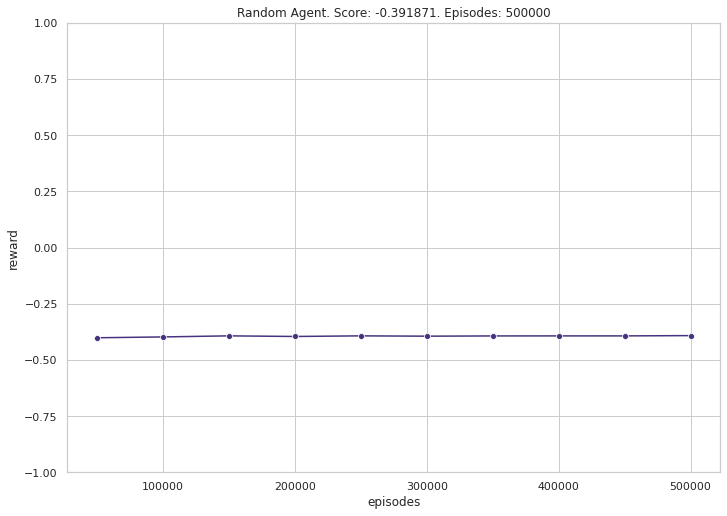

In [9]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    'Random Agent. Score: %f. Episodes: %d' % (final_score, EPISODES))

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [10]:
class StaticAgent:

    def __init__(self, env):
        self.env = env
    
    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag = self.env.reset()
        done = False
        reward = 0

        while not done:
            if 19 <= sum_hand <= 21:
                obs, reward, done, _ = self.env.step(STAND)
            else:
                obs, reward, done, _ = self.env.step(HIT)

        self.env.close()

        return reward

In [11]:
agent = StaticAgent(env)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.6693134328358209, 0.0021837801673727105)

[(-1.0, 1.0)]

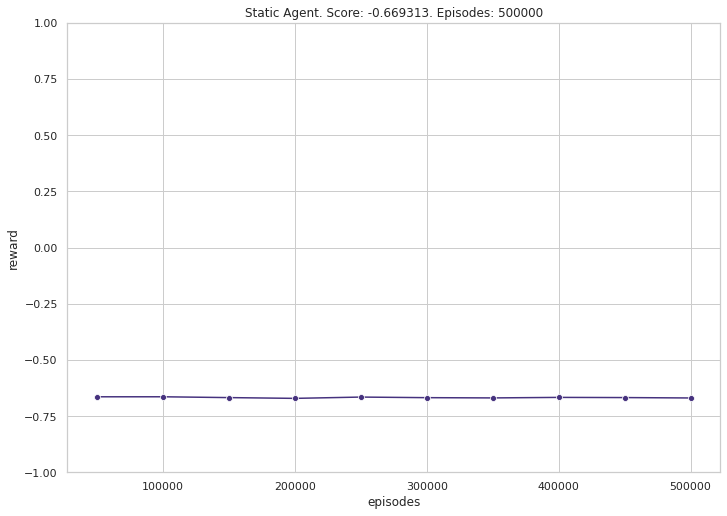

In [12]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title('Static Agent. Score: %f. Episodes: %d' % (final_score, EPISODES))

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [13]:
class QLearningAgent:

    def __init__(self, env, learning_rate=0.5, discount=0.5, eps=0.01):
        self.env = env
        self.Q = np.full((22, 11, 2), 0.5)
        self.learning_rate = learning_rate
        self.discount = discount
        self.eps = eps

    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag = self.env.reset()
        done = False
        reward = 0
        episode_log = []

        while not done:
            steps_scores = self.Q[sum_hand][dealer_open_card]
            
            if check_score:
                step = np.argmax(steps_scores)
            elif np.max(steps_scores) == np.min(steps_scores):
                step = random.randint(STAND, HIT)
            else:
                if not check_score and random.random() < self.eps:
                    step = random.randint(STAND, HIT) 
                else:
                    step = np.argmax(steps_scores)
            
            obs, reward, done, _ = self.env.step(step)
            episode_log.append((sum_hand, dealer_open_card, step))

            sum_hand, dealer_open_card, usable_ace_flag = obs

        self.env.close()
        
        if not check_score:
            max_Q_next  = reward

            for i in range(len(episode_log)):
                ind = len(episode_log) - 1 - i
                item = episode_log[ind]

                self.Q[item] = (
                    self.Q[item] + self.learning_rate * (
                        reward + self.discount * max_Q_next - self.Q[item])
                )

                max_Q_next = np.max(self.Q[item[:-1]])

        return reward

In [14]:
experiments = []

for learning_rate in {0.01, 0.1, 0.5, 1}:
    for discount in {0.01, 0.1, 0.5, 1}:
        agent = QLearningAgent(env, learning_rate=learning_rate, discount=discount)

        rewards, idx = run_all_episodes(agent, check_times=1)
        final_score = rewards[-1]

        experiments.append((learning_rate, discount, final_score))

experiments = sorted(experiments, key=lambda x: x[2], reverse=True)

for item in experiments:
    print(item)

LEARNING_RATE, DISCOUNT, _ = experiments[0]

(0.01, 0.01, -0.05502487562189055)
(0.01, 0.5, -0.056109452736318406)
(0.01, 1, -0.06106467661691542)
(0.1, 0.1, -0.06408955223880597)
(0.01, 0.1, -0.06445771144278607)
(0.1, 0.5, -0.07318407960199005)
(0.1, 0.01, -0.07850746268656716)
(0.5, 0.01, -0.07916417910447761)
(0.1, 1, -0.09618905472636816)
(0.5, 0.1, -0.10670646766169155)
(0.5, 0.5, -0.13783084577114427)
(0.5, 1, -0.17422885572139304)
(1, 0.01, -0.1863781094527363)
(1, 1, -0.18674626865671642)
(1, 0.5, -0.19024875621890547)
(1, 0.1, -0.22527363184079602)


In [15]:
agent = QLearningAgent(env, learning_rate=LEARNING_RATE, discount=DISCOUNT)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.06304477611940298, 0.011346124982347348)

[(-1.0, 1.0)]

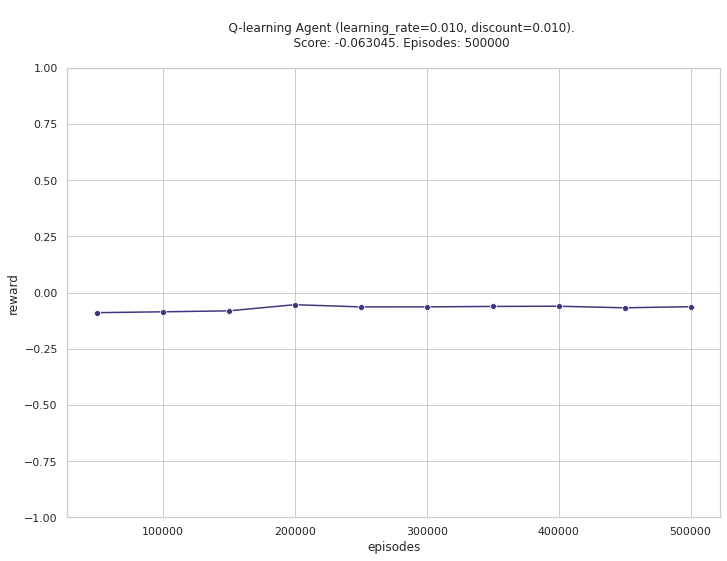

In [16]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    """
    Q-learning Agent (learning_rate=%.3f, discount=%.3f).
    Score: %f. Episodes: %d
    """ % (LEARNING_RATE, DISCOUNT, final_score, EPISODES)
)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [17]:
class MCAgent:

    def __init__(self, env, gamma=0.5, eps=0.5):
        self.env = env
        self.Q = np.full((22, 11, 2), 0.)

        for i in range(22):
            for j in range(11):
                for k in range(2):
                    self.Q[i, j, k] = random.random()

        self.R = {}
        self.gamma = gamma
        self.eps = eps

    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag = self.env.reset()
        done = False
        reward = 0
        episode_log = []

        while not done:
            steps_scores = self.Q[sum_hand][dealer_open_card]

            if check_score:
                step = np.argmax(steps_scores)
            elif np.max(steps_scores) == np.min(steps_scores):
                step = random.randint(STAND, HIT)
            else:
                if random.random() < self.eps:
                    step = random.randint(STAND, HIT)
                else:
                    step = np.argmax(steps_scores)
            
            obs, reward, done, _ = self.env.step(step)
            episode_log.append((sum_hand, dealer_open_card, step))

            sum_hand, dealer_open_card, usable_ace_flag = obs

        self.env.close()
        
        if not check_score:
            for i in range(len(episode_log)):
                ind = len(episode_log) - 1 - i
                item = episode_log[ind]

                g = (self.gamma ** i) * reward

                # if item not in self.R:
                #     self.R[item] = []

                # self.R[item].append(g)

                # self.Q[item[0], item[1], item[2]] = np.mean(self.R[item])

                if item not in self.R:
                    self.R[item] = [0, 0]

                self.R[item][0] += g
                self.R[item][1] += 1

                self.Q[item] = self.R[item][0] / self.R[item][1]

        return reward

In [18]:
experiments = []

for gamma in {0.01, 0.1, 0.5, 1}:
    for eps in {0.01, 0.05, 0.1}:
        agent = MCAgent(env, gamma=gamma, eps=eps)

        rewards, idx = run_all_episodes(agent, check_times=1)
        final_score = rewards[-1]

        experiments.append((gamma, eps, final_score))

experiments = sorted(experiments, key=lambda x: x[2], reverse=True)
        
for item in experiments:
    print(item)

GAMMA, EPS, _ = experiments[0]

(0.5, 0.1, -0.05460696517412935)
(0.1, 0.05, -0.05501492537313433)
(0.5, 0.05, -0.05573134328358209)
(0.01, 0.05, -0.05818905472636816)
(1, 0.1, -0.06026865671641791)
(0.5, 0.01, -0.061034825870646764)
(1, 0.05, -0.061960199004975125)
(0.1, 0.1, -0.06232835820895522)
(0.01, 0.1, -0.06271641791044776)
(0.1, 0.01, -0.06600995024875622)
(1, 0.01, -0.06778109452736318)
(0.01, 0.01, -0.06808955223880597)


In [19]:
agent = MCAgent(env, gamma=GAMMA, eps=EPS)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.05774129353233831, 0.004750905252194451)

[(-1.0, 1.0)]

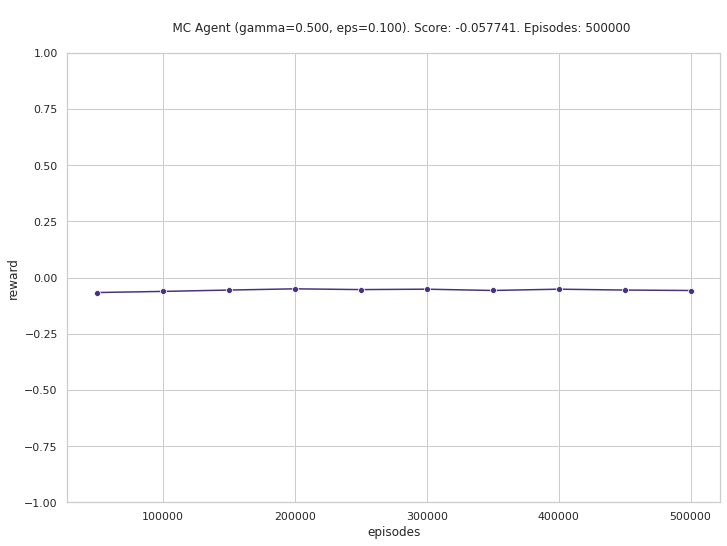

In [20]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    """
    MC Agent (gamma=%.3f, eps=%.3f). Score: %f. Episodes: %d
    """ % (GAMMA, EPS, final_score, EPISODES)
)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [21]:
class BlackjackDoubleDownEnv(gym.Env):

    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.seed()
        self.natural = natural
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:
            self.player.append(blackjack.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:
            if action > 1:
                self.player.append(blackjack.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = True
                while blackjack.sum_hand(self.dealer) < 17:
                    self.dealer.append(blackjack.draw_card(self.np_random))
                reward = blackjack.cmp(blackjack.score(self.player), blackjack.score(self.dealer))
                if self.natural and blackjack.is_natural(self.player) and reward == 1.:
                    reward = 1.5
            if action > 1:
                reward *= 2.
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (blackjack.sum_hand(self.player), self.dealer[0], blackjack.usable_ace(self.player))

    def reset(self):
        self.dealer = blackjack.draw_hand(self.np_random)
        self.player = blackjack.draw_hand(self.np_random)
        return self._get_obs()

In [22]:
class QLearningDoubleDownAgent:

    def __init__(self, env, learning_rate=0.5, discount=0.5, eps=0.01):
        self.env = env
        self.Q = np.full((22, 11, 3), 1 / 3)
        self.learning_rate = learning_rate
        self.discount = discount
        self.eps = eps

    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag = self.env.reset()
        done = False
        reward = 0
        episode_log = []

        while not done:
            steps_scores = self.Q[sum_hand][dealer_open_card]
            
            if check_score:
                step = np.argmax(steps_scores)
            elif np.max(steps_scores) == np.min(steps_scores):
                step = random.randint(0, 2)
            else:
                if random.random() < self.eps:
                    step = random.randint(0, 2)
                else:
                    step = np.argmax(steps_scores)
            
            obs, reward, done, _ = self.env.step(step)
            episode_log.append((sum_hand, dealer_open_card, step))

            sum_hand, dealer_open_card, usable_ace_flag = obs

        self. env.close()
        
        if not check_score:
            max_Q_next = reward

            for i in range(len(episode_log)):
                ind = len(episode_log) - 1 - i
                item = episode_log[ind]

                self.Q[item] = (
                    self.Q[item] + self.learning_rate * (
                        reward + self.discount * max_Q_next - self.Q[item])
                )

                max_Q_next = np.max(self.Q[item[:-1]])

        return reward

In [23]:
env = BlackjackDoubleDownEnv()

In [24]:
agent = QLearningDoubleDownAgent(
    env, learning_rate=LEARNING_RATE, discount=DISCOUNT)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.04570149253731343, 0.027449273240301955)

[(-1.0, 1.0)]

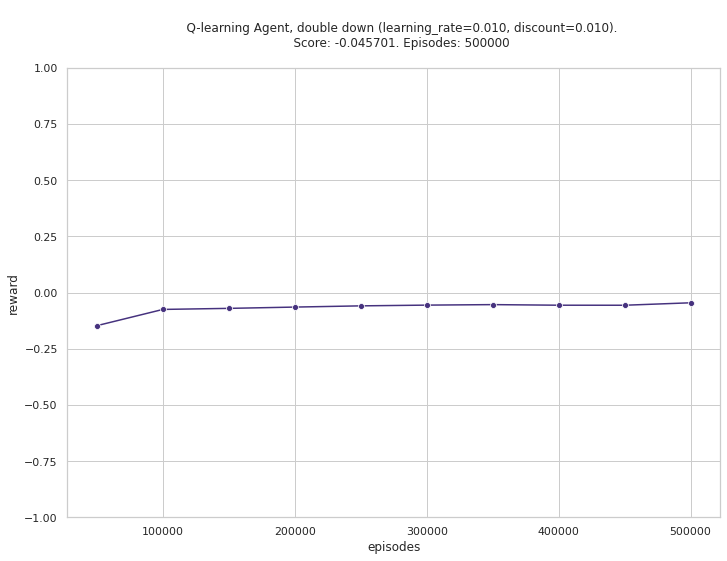

In [25]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    """
    Q-learning Agent, double down (learning_rate=%.3f, discount=%.3f).
    Score: %f. Episodes: %d
    """ % (LEARNING_RATE, DISCOUNT, final_score, EPISODES)
)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [26]:
class MCDoubleDownAgent:

    def __init__(self, env, gamma=0.5, eps=0.02):
        self.env = env
        self.Q = np.full((22, 11, 3), 0.)

        for i in range(22):
            for j in range(11):
                for k in range(3):
                    self.Q[i, j, k] = random.random()

        self.R = {}
        self.gamma = gamma
        self.eps = eps

    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag = self.env.reset()
        done = False
        reward = 0
        episode_log = []

        while not done:
            steps_scores = self.Q[sum_hand][dealer_open_card]

            if check_score:
                step = np.argmax(steps_scores)
            elif np.max(steps_scores) == np.min(steps_scores):
                step = random.randint(0, 2)
            else:
                if random.random() < self.eps:
                    step = random.randint(0, 2)
                else:
                    step = np.argmax(steps_scores)
            
            obs, reward, done, _ = self.env.step(step)
            episode_log.append((sum_hand, dealer_open_card, step))

            sum_hand, dealer_open_card, usable_ace_flag = obs

        self.env.close()
        
        if not check_score:
            for i in range(len(episode_log)):
                ind = len(episode_log) - 1 - i
                item = episode_log[ind]

                g = (self.gamma ** i) * reward

                # if item not in self.R:
                #     self.R[item] = []

                # self.R[item].append(g)

                # self.Q[item[0], item[1], item[2]] = np.mean(self.R[item])

                if item not in self.R:
                    self.R[item] = [0, 0]

                self.R[item][0] += g
                self.R[item][1] += 1

                self.Q[item] = self.R[item][0] / self.R[item][1]

        return reward

In [27]:
agent = MCDoubleDownAgent(env, gamma=GAMMA, eps=EPS)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.05082587064676617, 0.00708991420914124)

[(-1.0, 1.0)]

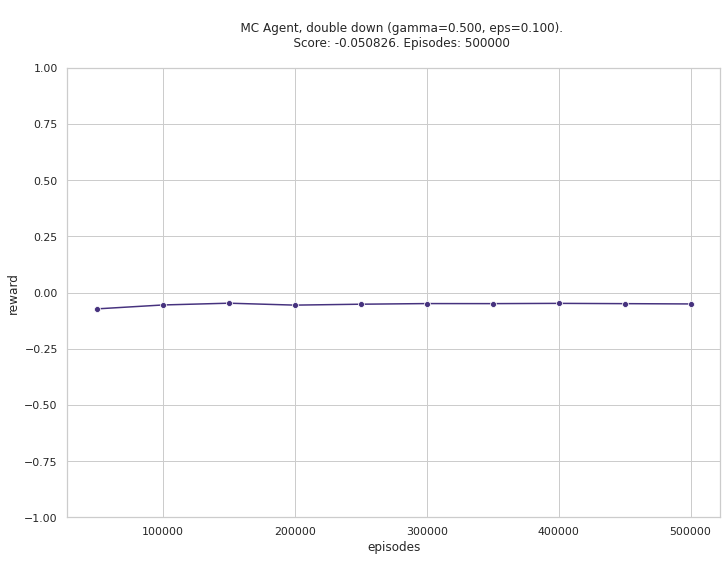

In [28]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    """
    MC Agent, double down (gamma=%.3f, eps=%.3f).
    Score: %f. Episodes: %d
    """ % (GAMMA, EPS, final_score, EPISODES)
)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [29]:
full_deck = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10
]

class BlackjackDoubleDownDeckMemoryEnv(gym.Env):

    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.seed()
        self.natural = natural
        self.deck = list(full_deck)
        self.deck_memory = []
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:
            self.player.append(self.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:
            if action > 1:
                self.player.append(self.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = True
                while blackjack.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = blackjack.cmp(blackjack.score(self.player), blackjack.score(self.dealer))
                if self.natural and blackjack.is_natural(self.player) and reward == 1.:
                    reward = 1.5
            if action > 1:
                reward *= 2.
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (
            blackjack.sum_hand(self.player),
            self.dealer[0],
            blackjack.usable_ace(self.player),
            self.deck_memory
        )
    
    def draw_card(self, np_random, is_open=True):
        choice =  int(np_random.choice(self.deck))
        self.deck.remove(choice)
        if is_open:
            self.deck_memory.append(choice)
        if len(self.deck) < 15:
            self.deck = list(full_deck)
            self.deck_memory = []
        return choice
    
    def draw_hand(self, np_random, is_dealer=False):
        if is_dealer:
            return [self.draw_card(np_random), self.draw_card(np_random, is_open=False)]
        return [self.draw_card(np_random), self.draw_card(np_random)]

    def reset(self):
        self.dealer = self.draw_hand(self.np_random, is_dealer=True)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

In [30]:
class QLearningDoubleDownDeckMemoryAgent:

    def __init__(self, env, learning_rate=0.5, discount=0.5, eps=0.01):
        self.env = env
        self.Q = np.full((22, 11, 2, 52, 3), 1 / 3)
        self.learning_rate = learning_rate
        self.discount = discount
        self.eps = eps

    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag, deck_memory = self.env.reset()
        done = False
        reward = 0
        episode_log = []

        while not done:
            cards_score = self.count_cards(deck_memory)
            usable_ace = 0 if not usable_ace_flag else 1
            steps_scores = self.Q[sum_hand][dealer_open_card][usable_ace][cards_score]
            
            if check_score:
                step = np.argmax(steps_scores)
            elif np.max(steps_scores) == np.min(steps_scores):
                step = random.randint(0, 2)
            else:
                if random.random() < self.eps:
                    step = random.randint(0, 2)
                else:
                    step = np.argmax(steps_scores)
            
            obs, reward, done, _ = self.env.step(step)
            episode_log.append((sum_hand, dealer_open_card, usable_ace, cards_score, step))

            sum_hand, dealer_open_card, usable_ace_flag, deck_memory = obs

        self.env.close()
        
        if not check_score:
            max_Q_next = reward

            for i in range(len(episode_log)):
                ind = len(episode_log) - 1 - i
                item = episode_log[ind]

                self.Q[item] = (
                    self.Q[item] + self.learning_rate * (
                        reward + self.discount * max_Q_next - self.Q[item])
                )

                max_Q_next = np.max(self.Q[item[:-1]])

        return reward
    
    def count_cards(self, deck):
        result = 0
        for item in deck:
            if item in {2, 3, 4, 5, 6}:
                result += 1
            elif item in {1, 10}:
                result -= 1
        return result + 20

In [31]:
env = BlackjackDoubleDownDeckMemoryEnv()

In [32]:
agent = QLearningDoubleDownDeckMemoryAgent(
    env, learning_rate=LEARNING_RATE, discount=DISCOUNT)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.09691542288557214, 0.030744413813216524)

[(-1.0, 1.0)]

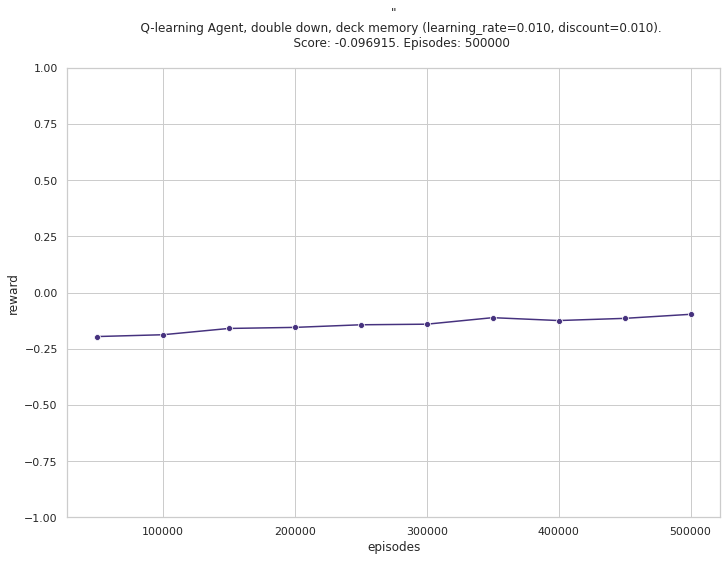

In [33]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    """"
    Q-learning Agent, double down, deck memory (learning_rate=%.3f, discount=%.3f).
    Score: %f. Episodes: %d
    """ % (LEARNING_RATE, DISCOUNT, final_score, EPISODES)
)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [34]:
class MCDoubleDownDeckMemoryAgent:

    def __init__(self, env, gamma=0.5, eps=0.02):
        self.env = env
        self.Q = np.full((22, 11, 2, 52, 3), 0.)

        for i in range(22):
            for j in range(11):
                for k in range(2):
                    for t in range(52):
                        for m in range(3):
                            self.Q[i, j, k, t, m] = random.random()
        self.R = {}
        self.gamma = gamma
        self.eps = eps

    def run_episode(self, check_score=False):
        sum_hand, dealer_open_card, usable_ace_flag , deck_memory= self.env.reset()
        done = False
        reward = 0
        episode_log = []

        while not done:
            cards_score = self.count_cards(deck_memory)
            usable_ace = 0 if not usable_ace_flag else 1
            steps_scores = self.Q[sum_hand][dealer_open_card][usable_ace][cards_score]

            if check_score:
                step = np.argmax(steps_scores)  
            elif np.max(steps_scores) == np.min(steps_scores):
                step = random.randint(0, 2)
            else:
                if random.random() < self.eps:
                    step = random.randint(0, 2)
                else:
                    step = np.argmax(steps_scores)
            
            obs, reward, done, _ = self.env.step(step)
            episode_log.append((sum_hand, dealer_open_card, usable_ace, cards_score, step))

            sum_hand, dealer_open_card, usable_ace_flag, deck_memory = obs

        self.env.close()
        
        if not check_score:
            for i in range(len(episode_log)):
                ind = len(episode_log) - 1 - i
                item = episode_log[ind]

                g = (self.gamma ** i) * reward

                # if item not in self.R:
                #     self.R[item] = []

                # self.R[item].append(g)

                # self.Q[item] = np.mean(self.R[item])

                if item not in self.R:
                    self.R[item] = [0, 0]

                self.R[item][0] += g
                self.R[item][1] += 1

                self.Q[item] = self.R[item][0] / self.R[item][1]

        return reward

    def count_cards(self, deck):
        result = 0
        for item in deck:
            if item in {2, 3, 4, 5, 6}:
                result += 1
            elif item in {1, 10}:
                result -= 1
        return result + 20

In [35]:
agent = MCDoubleDownDeckMemoryAgent(env, gamma=GAMMA, eps=EPS)

rewards, idx = run_all_episodes(agent)

final_score, scores_std = rewards[-1], np.std(rewards)
final_score, scores_std

(-0.05667661691542288, 0.01876314186605816)

[(-1.0, 1.0)]

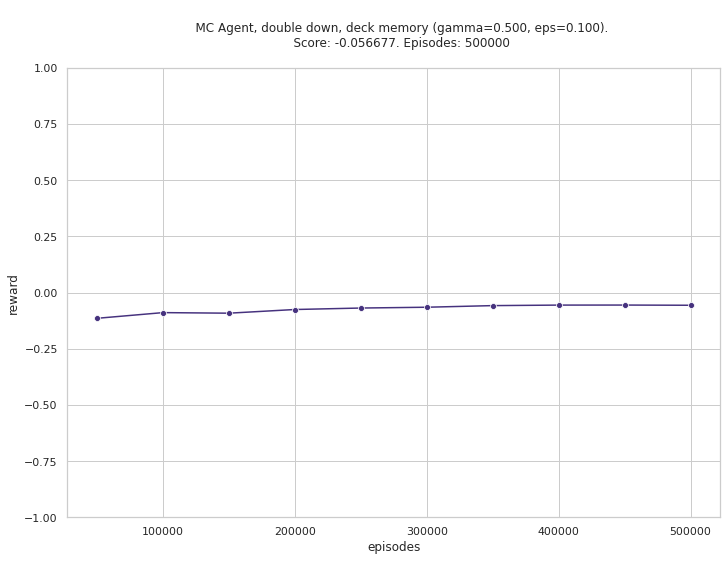

In [36]:
g = sns.lineplot(x=idx, y=rewards, marker='o')

g.set_title(
    """
    MC Agent, double down, deck memory (gamma=%.3f, eps=%.3f).
    Score: %f. Episodes: %d
    """ % (GAMMA, EPS, final_score, EPISODES)
)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-1, 1))

In [37]:
def run_all():
    stat = pd.DataFrame()

    env1 = gym.make("Blackjack-v0")
    env2 = BlackjackDoubleDownEnv()
    env3 = BlackjackDoubleDownDeckMemoryEnv()
    
    agents = [
        (
            "Q-learning Agent",
            QLearningAgent,
            (env1, LEARNING_RATE, DISCOUNT)
        ),
        (
            "MC Agent",
            MCAgent,
            (env1, GAMMA, EPS)
        ),
        (
            "Q-learning Agent, double down",
            QLearningDoubleDownAgent,
            (env2, LEARNING_RATE, DISCOUNT)
        ),
        (
            "MC Agent, double down",
            MCDoubleDownAgent,
            (env2, GAMMA, EPS)
        ),
        (
            "Q-learning Agent, double down, deck memory",
            QLearningDoubleDownDeckMemoryAgent,
            (env3, LEARNING_RATE, DISCOUNT)
        ),
        (
            "MC Agent, double down, deck memory",
            MCDoubleDownDeckMemoryAgent,
            (env3, GAMMA, EPS)
        )
    ]
    
    for item in agents:
        name, builder, args = item

        agent = builder(*args)

        rewards, idx = run_all_episodes(agent)
        score, std = rewards[-1], np.mean(rewards)
        
        if "idx" not in stat.columns:
            stat["idx"] = idx

        stat["%f %s" % (score, name)] = rewards

        print("score: %f, std: %f - %s" % (score, std, name))

        del agent

    return stat

In [38]:
EPISODES = int(1e7)
SCORE_EPISODES = 100500

stat = run_all()

score: -0.057114, std: -0.059658 - Q-learning Agent
score: -0.047204, std: -0.054935 - MC Agent
score: -0.050318, std: -0.050180 - Q-learning Agent, double down
score: -0.040975, std: -0.043662 - MC Agent, double down
score: -0.036597, std: -0.045765 - Q-learning Agent, double down, deck memory
score: -0.030090, std: -0.033335 - MC Agent, double down, deck memory


[(-0.1, 0.1)]

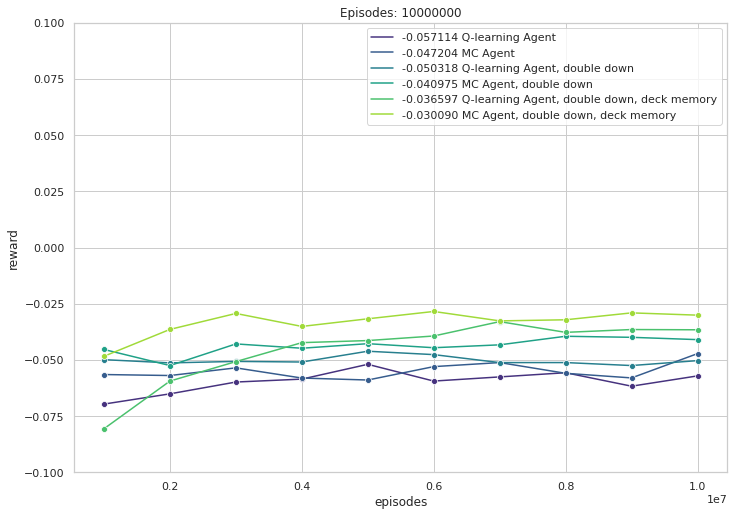

In [39]:
g = sns.lineplot(data=stat.set_index("idx"), marker='o', dashes=None)

g.set_title('Episodes: %d' % EPISODES)

g.set_ylabel('reward')
g.set_xlabel('episodes')
g.set(ylim=(-0.1, 0.1))